# Scoring the Interest of a Response

**Goal**: Score responses by how interesting they may be.

**Properties of an Interesting Response (for our purposes)**:
- greater length
- variation of ideas (not paraphrasing the same sentences repeatedly)
- discussion of certain topics
  - race
  - gender
  - combat
  - training
- lack of discussion of certain topics
  - general comments about the survey itself
- clarity of response
  - few "unclear" tags

The "interest_training.xlsx" file contains a curated sample of responses from multiple surveys which we will use to develop a model for scoring how "interesting" a response is overall.

In [1]:
import pandas as pd

In [2]:
# Read in Survey data
path = "../data/interest_training.xlsx"
col = "response"
df = pd.read_excel(path, na_filter=False, dtype={col: str})

## Collecting Subscores

First, we consider the length of a response by measuring the number of characters. (Note that counting the number of sentences was also considered, but this ended up being too similar to the rank and including it greatly weakened the model.

In [3]:
df['len_char'] = df[col].apply(len)

### Response Sentence Similarity

Next, we'll use BERT to score the similarity of sentences in a given response.

In [4]:
from itertools import combinations
import numpy as np
from scipy.spatial.distance import cosine
import nltk

In [5]:
from sentence_transformers import SentenceTransformer
model_sen = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
;

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

''

In [6]:
def similarity(res):
    
    # Split response into sentences
    res_split = nltk.sent_tokenize(res)
    
    # Embed each sentence
    res_embed = model_sen.encode(res_split)
    
    # Get the rank of the response embedding matrix
    # where each column is a different sentence
    rank = np.linalg.matrix_rank(np.transpose(res_embed))
    
    # Too few sentences to do any comparison
    if len(res_split) < 2:
        return 0,0,0,0,rank
    
    # Compare combinations of sentences
    # Responses generally have few enough sentences that this is reasonable
    sim = [1 - cosine(c[0], c[1]) for c in combinations(res_embed,2)]
    
    # Return the min, max, mean, median sentence similarities
    # as well as the rank and number of sentences
    return np.amin(sim), np.amax(sim), np.mean(sim), np.median(sim), rank

In [7]:
# Apply function and unpack results
res = df[col].apply(similarity)
df['min']     = [r[0] for r in res]
df['max']     = [r[1] for r in res]
df['mean']    = [r[2] for r in res]
df['median']  = [r[3] for r in res]
df['rank']    = [r[4] for r in res]

### Response Topic

Finally, we will use BERT again to determine if a given response discusses certain topics. For a more detailed explanation of our BERT-contextualized keyword searching method, read through the "LongResponse_Filtering" notebook.

In [8]:
import torch

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()
;

''

In [9]:
# From https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
def get_token_embeddings(text):
    
    # Tokenize the text
    split_text = text.split(". ")
    marked_text = "[CLS] " + " [SEP] ".join(split_text) + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)[:512] # Truncate if longer than 512
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Mark tokens belonging to a sentence
    segment_ids = [0]*len(tokenized_text)
    is_zero = True
    for i in range(len(tokenized_text)):
        segment_ids[i] = 0 if is_zero else 1
        if tokenized_text[i] == "[SEP]":
            is_zero = not is_zero

    # Convert to torch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segment_ids])

    # Run through BERT
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    # Adjust
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    # Get token vectors
    token_vecs_sum = []
    for token in token_embeddings:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    return token_vecs_sum

In [10]:
# Track the number of words in a given text that have
#   a high similarity to at least one keyword.
# Also track the highest similarity scores

# df: Dataframe
# column: column to consider for labeling
# label: name of column to store results in
# keys: keyword dictionary
# thresh: similarity threshold
def label_topic(df, column, label, keys, thresh):

    # Initialize/Reset column
    df[label] = 0
    df[label+"_score"] = float("-inf")
    
    # Track tokens that matched to keywords
    token_matches = []
    
    # Search
    for i in range(len(df)):
        best_sim = float("-inf")
        embed = get_token_embeddings(df[column][i])
        for j in range(len(embed)):
            for k in keys:
                sim = 1 - cosine(embed[j], k['embed'])
                if sim > best_sim:
                    best_sim = sim
                if sim >= thresh:
                    df.at[i, label] += 1
                    
                    # Get the token that matched to a keyword
                    split_text = df[column][i].split(". ")
                    marked_text = "[CLS] " + " [SEP] ".join(split_text) + " [SEP]"
                    tokenized_text = tokenizer.tokenize(marked_text)
                    token_matches.append((tokenized_text[j], k['text']))
                    
                    break
        
        df.at[i, label+"_score"] = best_sim
        
        # Track progress
        #if i%100==0:
        #    print(i,"/",len(df))
                    
    return token_matches

Some topics have been predetermined to be particularly interesting or uninteresting for the prosepective audience. First, we will consider the interesting topics.

In [11]:
# Topic 1: Race
keys_race = [
    {"text": "negro soldier", "idx": 1, "embed": None},
    {"text": "the white man", "idx": 2, "embed": None}
]

for k in keys_race:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]
    
    
token_matches = label_topic(df, col, 'topic_race', keys_race, 0.5)
print(set(token_matches))

{('##es', 'negro soldier'), ('white', 'negro soldier'), ('northern', 'negro soldier'), ('##s', 'negro soldier'), ('whites', 'negro soldier'), ('colored', 'negro soldier'), ('south', 'negro soldier'), ('north', 'negro soldier'), ('tough', 'negro soldier'), ('color', 'negro soldier'), ('white', 'the white man'), ('negro', 'negro soldier'), ('cattle', 'the white man'), ('southern', 'negro soldier'), ('soldiers', 'negro soldier'), ('chinese', 'negro soldier')}


In [12]:
# Topic 2: Gender
keys_gender = [
    {"text": "woman", "idx": 1, "embed": None}
]

man_embed = get_token_embeddings("man")[1]
for k in keys_gender:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']] - (np.dot(embed[k['idx']], man_embed) / np.dot(man_embed, man_embed)) * man_embed
    
token_matches = label_topic(df, col, 'topic_gender', keys_gender, 0.3)
print(set(token_matches))

{('married', 'woman'), ('wife', 'woman'), ('women', 'woman')}


In [ ]:
# TO DO: Expand the list of topics as requested

Now we will consider the uninteresting topics.

In [13]:
# Topic 1: Survey
keys_survey = [
    {"text": "this is a good questionnaire", "idx": 5, "embed": None},
    {"text": "too many questions", "idx": 3, "embed": None},
    {"text": "questions about", "idx": 1, "embed": None},
]

for k in keys_survey:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]
    

token_matches = label_topic(df, col, 'topic_survey', keys_survey, 0.6)
print(set(token_matches))

{('question', 'too many questions'), ('ideas', 'too many questions'), ('question', 'this is a good questionnaire'), ('questions', 'this is a good questionnaire'), ('questions', 'too many questions'), ('asked', 'too many questions'), ('##naire', 'this is a good questionnaire')}


In [14]:
# Topic 2: "No comments"
keys_comment = [
    {"text": "I have nothing else to say", "idx": 3, "embed": None},
    {"text": "no comments", "idx": 2, "embed": None},
    {"text": "nothing to add", "idx": 1, "embed": None},
    {"text": "I have none", "idx": 3, "embed": None},
]

for k in keys_comment:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]
    

token_matches = label_topic(df, col, 'topic_comment', keys_comment, 0.70)
print(set(token_matches))

{('no', 'nothing to add'), ('comments', 'no comments'), ('none', 'I have none')}


### Response Clarity

In [32]:
def clarity(res):
    if res.count("unclear") == 0:
        return 0
    return res.count("unclear") / len(res.split())

df['clarity'] = df[col].apply(clarity)

## Interest Function

Now, we will use these results along with predetermined answers as to whether or not a response is interesting to construct a model for scoring the interest of a resposne.

In [33]:
# Grab rows for training
A = df[["len_char", "min", "max", "mean", "median", "rank", "topic_survey",
        "topic_survey_score", "topic_comment", "topic_comment_score", "clarity"]]
b = df[["interest"]] # predetermined interest

In [34]:
import matplotlib.pyplot as plt

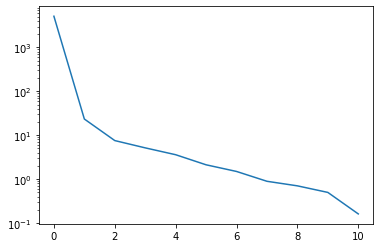

In [35]:
# Plot singular values of A
U,S,Vt = np.linalg.svd(A, full_matrices=False)
plt.semilogy(S)

### Inverse Problem

In [86]:
# Solve: Ax = b
x = (Vt.T)*(1/S)@(U.T@b)

print("len_char:           ", x.iloc[ 0]['interest'])
print("min:                ", x.iloc[ 1]['interest'])
print("max:                ", x.iloc[ 2]['interest'])
print("mean:               ", x.iloc[ 3]['interest'])
print("median:             ", x.iloc[ 4]['interest'])
print("rank:               ", x.iloc[ 5]['interest'])
print("topic_survey:       ", x.iloc[ 6]['interest'])
print("topic_survey_score: ", x.iloc[ 7]['interest'])
print("topic_comment:      ", x.iloc[ 8]['interest'])
print("topic_comment_score:", x.iloc[ 9]['interest'])
print("clarity:            ", x.iloc[10]['interest'])

len_char:            0.0005499328530886769
min:                 0.17943940546253914
max:                 -0.28931352264366167
mean:                1.468063223740845
median:              -1.2308136602304747
rank:                0.024345777632150265
topic_survey:        0.11086410189840624
topic_survey_score:  -0.4000235699670328
topic_comment:       -0.08412383628239575
topic_comment_score: 0.27711083687464166
clarity:             -0.42591282694257143


Note that each entry in "x" can be modified to further fine-tune results.

In [81]:
#x.iloc[10]['interest'] = -1.8

The dot product of a vector of subscores with x gives the interest score.

In [87]:
def score(r):
    return np.dot([r['len_char'], r['min'], r['max'], r['mean'], 
                   r['median'], r['rank'], r['topic_survey'], r['topic_survey_score'], 
                   r['clarity'], r['topic_comment'], r['topic_comment_score']], x)[0]
    
df['interest_score'] = df.apply(score, axis=1)

In [88]:
# Save results to excel
df.to_excel(path, index=False)

## Applying Interest Function to Other Surveys

In [94]:
def interest_score(path, col, encoding = 'cp1252'):
    df = pd.read_csv(path, na_filter=False, dtype={col: str}, encoding=encoding)
    
    df['len_char'] = df[col].apply(len)
    
    res = df[col].apply(similarity)
    df['min']     = [r[0] for r in res]
    df['max']     = [r[1] for r in res]
    df['mean']    = [r[2] for r in res]
    df['median']  = [r[3] for r in res]
    df['rank']    = [r[4] for r in res]
    
    #token_matches = label_topic(df, col, 'topic_race', keys_race, 0.5)
    #print(set(token_matches), "\n")
    
    #token_matches = label_topic(df, col, 'topic_gender', keys_gender, 0.3)
    #print(set(token_matches), "\n")
    
    token_matches = label_topic(df, col, 'topic_survey', keys_survey, 0.6)
    print(set(token_matches), "\n")
    
    token_matches = label_topic(df, col, 'topic_comment', keys_comment, 0.70)
    print(set(token_matches))
    
    df['clarity'] = df[col].apply(clarity)
    
    df['interest_score'] = df.apply(score, axis=1)
    
    df.to_csv(path, index=False)

In [23]:
interest_score("../data/Survey_100A_pivoted.csv", "answer")

{('africa', 'negro soldier'), ('american', 'negro soldier'), ('natives', 'negro soldier'), ('enlisted', 'negro soldier'), ('white', 'the white man'), ('negro', 'negro soldier'), ('southern', 'negro soldier')} 

{('wives', 'woman'), ('woman', 'woman'), ('wife', 'woman'), ('women', 'woman'), ('men', 'woman'), ('paper', 'woman'), ('married', 'woman'), ('unclear', 'woman')} 

{('question', 'too many questions'), ('answer', 'too many questions'), ('suggestions', 'too many questions'), ('question', 'this is a good questionnaire'), ('questions', 'this is a good questionnaire'), ('questions', 'too many questions'), ('editorial', 'questions about'), ('articles', 'questions about'), ('facts', 'questions about')} 

{('suggestions', 'no comments'), ('no', 'nothing to add'), ('none', 'I have none')}


In [24]:
interest_score("../data/Survey_100B_pivoted.csv", "answer")

{('black', 'negro soldier'), ('##o', 'negro soldier'), ('white', 'negro soldier'), ('yellow', 'the white man'), ('slaves', 'negro soldier'), ('jungle', 'negro soldier'), ('enlisted', 'negro soldier'), ('white', 'the white man'), ('##gger', 'negro soldier'), ('chinese', 'negro soldier')} 

{('wives', 'woman'), ('woman', 'woman'), ('wife', 'woman'), ('sex', 'woman'), ('men', 'woman'), ('women', 'woman'), ('girl', 'woman'), ('married', 'woman'), ('to', 'woman')} 

{('question', 'too many questions'), ('ask', 'too many questions'), ('question', 'this is a good questionnaire'), ('questions', 'this is a good questionnaire'), ('questions', 'too many questions'), ('ask', 'questions about')} 

{('none', 'I have none'), ('remarks', 'no comments'), ('nothing', 'I have nothing else to say')}


In [89]:
interest_score("../data/Survey_100C_pivoted.csv", "answer")

In [26]:
interest_score("../data/Survey_100D_pivoted.csv", "answer")

{('black', 'negro soldier'), ('white', 'negro soldier'), ('yellow', 'the white man'), ('racial', 'negro soldier'), ('enlisted', 'negro soldier')} 

{('wife', 'woman')} 

{('concerning', 'questions about'), ('problems', 'too many questions'), ('questions', 'too many questions'), ('question', 'this is a good questionnaire')} 

{('remarks', 'no comments')}


In [27]:
interest_score("../data/Survey_100E_pivoted.csv", "answer")

{('black', 'negro soldier'), ('white', 'negro soldier'), ('yellow', 'the white man'), ('slaves', 'negro soldier'), ('jungle', 'negro soldier'), ('enlisted', 'negro soldier'), ('white', 'the white man'), ('negro', 'negro soldier'), ('yankee', 'negro soldier')} 

{('wives', 'woman'), ('girlfriend', 'woman'), ('woman', 'woman'), ('wife', 'woman'), ('men', 'woman'), ('women', 'woman'), ('couples', 'woman'), ('girl', 'woman'), ('married', 'woman')} 

{('question', 'too many questions'), ('questions', 'too many questions'), ('question', 'this is a good questionnaire')} 

{('none', 'I have none')}


In [28]:
interest_score("../data/Survey_100F_pivoted.csv", "answer")

{('black', 'negro soldier'), ('slave', 'negro soldier'), ('white', 'negro soldier'), ('jungle', 'negro soldier'), ('white', 'the white man')} 

{('wives', 'woman'), ('woman', 'woman'), ('wife', 'woman'), ('women', 'woman')} 

{('question', 'too many questions'), ('question', 'this is a good questionnaire'), ('questions', 'this is a good questionnaire'), ('questions', 'too many questions'), ('asked', 'too many questions')} 

{('none', 'I have none')}


In [29]:
interest_score("../data/Survey_100G_pivoted.csv", "answer", 'utf8')

set() 

{('men', 'woman'), ('women', 'woman')} 

{('questions', 'this is a good questionnaire'), ('answer', 'too many questions'), ('question', 'this is a good questionnaire')} 

{('nothing', 'nothing to add'), ('comment', 'no comments'), ('none', 'I have none')}


In [95]:
interest_score("../data/Survey_32N_pivoted.csv", "answer", 'utf8')

{('comments', 'questions about'), ('questioning', 'too many questions'), ('questions', 'too many questions'), ('answers', 'questions about'), ('facts', 'too many questions'), ('answer', 'this is a good questionnaire'), ('question', 'this is a good questionnaire'), ('questions', 'this is a good questionnaire'), ('question', 'questions about'), ('asked', 'too many questions'), ('##naire', 'this is a good questionnaire'), ('asks', 'too many questions'), ('answers', 'too many questions'), ('question', 'too many questions'), ('answer', 'too many questions'), ('questions', 'questions about'), ('ask', 'too many questions'), ('asked', 'questions about'), ('query', 'this is a good questionnaire')} 

{('nothing', 'nothing to add'), ('comment', 'no comments'), ('none', 'I have none'), ('one', 'I have none'), ('nothing', 'I have nothing else to say'), ('comments', 'no comments')}


In [97]:
interest_score("../data/Survey_32W_pivoted.csv", "answer")

{('comments', 'questions about'), ('questions', 'too many questions'), ('answers', 'questions about'), ('answer', 'this is a good questionnaire'), ('question', 'this is a good questionnaire'), ('questions', 'this is a good questionnaire'), ('question', 'questions about'), ('ask', 'questions about'), ('asked', 'too many questions'), ('##naire', 'this is a good questionnaire'), ('restrictions', 'too many questions'), ('difficulties', 'questions about'), ('ideas', 'too many questions'), ('##der', 'questions about'), ('answers', 'too many questions'), ('examinations', 'too many questions'), ('question', 'too many questions'), ('answer', 'too many questions'), ('questions', 'questions about'), ('ask', 'too many questions')} 

{('any', 'I have none'), ('comment', 'no comments'), ('none', 'I have none'), ('nothing', 'I have nothing else to say'), ('no', 'nothing to add'), ('comments', 'no comments')}


# Appendix

## Using BERT to Embed Multi-Sentence Responses

To embed individual sentences, we used Sentence-BERT which is a tool extending BERT's base functionality to give "semantially meaningful sentence embeddings". The resulting embeddings from this method are comparable using cosine similarity [https://arxiv.org/abs/1908.10084]. 

In the following section, we demonstrate the use of Sentence-BERT to obtain comparable sentence embeddings.

### Sentence-BERT Demonstration

Ideally, we would expect similar sentences to have similar embeddings. For each pair of example sentences, we will measure the cosine similarity of their embeddings.

In [ ]:
# Example text
example_set_1 = [
    ['I like dogs.', 'I love dogs.'],
    ['I like dogs.', 'I want a puppy.'],
    ['I like dogs.', 'I like cats.'],
    ['I like dogs.', 'I want food.'],
    ['I like dogs.', 'The hound ran around the yard.'],
    ['I like dogs.', "It snowed today."]
]

In [ ]:
from prettytable import PrettyTable
from textwrap import fill

In [ ]:
def compare_text(example_set):
    
    # Initialize table
    t = PrettyTable(['Excerpt A', 'Excerpt B', 'Similarity'])
    
    for e in example_set:
        
        # Get embeddings for example
        embed = model_sen.encode(e)
        
        # Calculate cosine similarity
        sim = 1 - cosine(embed[0], embed[1])
        
        # Add results to table
        t.add_row([fill(e[0], width=35), fill(e[1], width=35), round(sim,3)])
        
    # Display table
    print(t)

In [ ]:
compare_text(example_set_1)

### Embedding Multi-Sentence Responses

In the "LongResponse_Embedding" notebooks, different methods of embedding responses that may be multi-sentence were considered. For this purpose, we will revist Method 1 which simply passes the full response to the Sentence-BERT encoding function with no special handling.

This method is demonstrated below:

In [ ]:
example_set_2 = [
    [
        "The ground was covered in snow. Icicles hung from branches. Snowflakes kept falling.",
        "Winter has brought the coldest weather. This blizzard seems endless."
    ],
    [
        "Winter has brought the coldest weather. This blizzard seems endless.",
        "Rain waters the blooming flowers. Spring is finally here."
    ],
    [
        "Winter has brought the coldest weather. This blizzard seems endless.",
        "The table was filled with delicious food. I couldn't decide which dish to start with."
    ],
    [
        "The table was filled with delicious food. I couldn't decide which dish to start with.",
        "The smell coming from the stove is mouth-watering."
    ]
]

In [ ]:
compare_text(example_set_2)

From these results, we see that the embeddings of short multi-sentence pieces are still useful. For our purposes, the longest of survey responses are still just a few sentences, so we will assume most embeddings will not be too diluted for use.